In [10]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from utilities import read_xml


In [19]:
# Import
PATH_DEV = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_dev.txt')
PATH_TEST = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_test.txt')
PATH_TRAIN = os.path.join(os.getcwd(), 'origdata', 'BlurbGenreCollection_EN_train.txt')

df_train = read_xml(PATH_TRAIN)
df_test = read_xml(PATH_TEST)
df_dev = read_xml(PATH_DEV)

frames = [df_train, df_test, df_dev]
df = pd.concat(frames)

df.head()

# test


,TITLE,AUTHOR,PUBLISHED,ISBN,PAGE_NUM,URL,TOPICS,COPYRIGHT,DESCRIPTION,DATE,LANGUAGE
0,The New York Times Daily Crossword Puzzles: Th...,New York Times,"Dec 28, 1996",9780804115827,224 Pages,https://www.penguinrandomhouse.com/books/12309...,"Nonfiction, Games",(c) Penguin Random House,Monday’s Crosswords Do with EaseTuesday’s Cros...,2018-08-18,en
1,Creatures of the Night (Second Edition),Neil Gaiman,"Nov 29, 2016",9781506700250,48 Pages,https://www.penguinrandomhouse.com/books/53958...,"Fiction, Graphic Novels Manga",(c) Penguin Random House,Two of literary comics modern masters present ...,2018-08-18,en
2,Cornelia and the Audacious Escapades of the So...,Lesley M. M. Blume,"Jan 08, 2008",9780440421108,272 Pages,https://www.penguinrandomhouse.com/books/15160...,"Children’s Books, Children’s Middle Grade Books",(c) Penguin Random House,Eleven-year-old Cornelia is the daughter of tw...,2018-08-18,en
3,The Alchemist's Daughter,Katharine McMahon,"Oct 24, 2006",9780307335852,352 Pages,https://www.penguinrandomhouse.com/books/11223...,"Fiction, Historical Fiction",(c) Penguin Random House,"During the English Age of Reason, a woman cloi...",2018-08-18,en
4,Dangerous Boy,Mandy Hubbard,"Aug 30, 2012",9781101575017,272 Pages,https://www.penguinrandomhouse.com/books/30534...,"Teen Young Adult, Teen Young Adult Mystery ...",(c) Penguin Random House,A modern-day retelling of The Strange Case of ...,2018-08-18,en


In [12]:
# Basic Statistic
print('Number of datasets: ', df.shape[0])
print('Number of columns: ', df.shape[1])
print('Columns: ', ', '.join(df.columns))


Number of datasets:  91894
Number of columns:  11
Columns:  TITLE, AUTHOR, PUBLISHED, ISBN, PAGE_NUM, URL, TOPICS, COPYRIGHT, DESCRIPTION, DATE, LANGUAGE


In [13]:
import re

reduced_topics = [
    "Fiction", "Children’s Books", "Nonfiction",
    "Poetry", "Humor", "Classics", "Young Adult"
]

def assign_primary_topic(topic_string):
    topics = [t.strip() for t in re.split(r',\s*', topic_string)]
    for reduced_topic in reduced_topics:
        for t in topics:
            if reduced_topic.lower() in t.lower():
                return reduced_topic
    return "Other"

df['TOPIC_MAIN'] = df['TOPICS'].apply(assign_primary_topic)

print("Distribution of assigned main topics:")
print(df['TOPIC_MAIN'].value_counts())


Distribution of assigned main topics:
TOPIC_MAIN
Fiction             70472
Children’s Books    19521
Poetry               1020
Humor                 460
Classics              421
Name: count, dtype: int64


In [14]:
df = df[df['TOPIC_MAIN'] != 'Other']


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_description(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['DESCRIPTION_CLEAN'] = df['DESCRIPTION'].fillna('').apply(clean_description)

vectorizer = TfidfVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

X_tfidf = vectorizer.fit_transform(df['DESCRIPTION_CLEAN'])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print("Sample feature names:", vectorizer.get_feature_names_out()[:10])


TF-IDF matrix shape: (91894, 8000)
Sample feature names: ['aaron' 'abandon' 'abandoned' 'abbey' 'abby' 'abilities' 'ability' 'able'
 'aboard' 'abortion']


In [16]:
from sklearn.model_selection import train_test_split

y = df['TOPIC_MAIN']
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Classification Report:
                  precision    recall  f1-score   support

Children’s Books       0.83      0.93      0.88      3904
        Classics       0.16      0.67      0.26        84
         Fiction       0.98      0.91      0.94     14095
           Humor       0.22      0.57      0.32        92
          Poetry       0.64      0.89      0.74       204

        accuracy                           0.91     18379
       macro avg       0.57      0.79      0.63     18379
    weighted avg       0.94      0.91      0.92     18379

Macro F1-Score: 0.6294700689440351


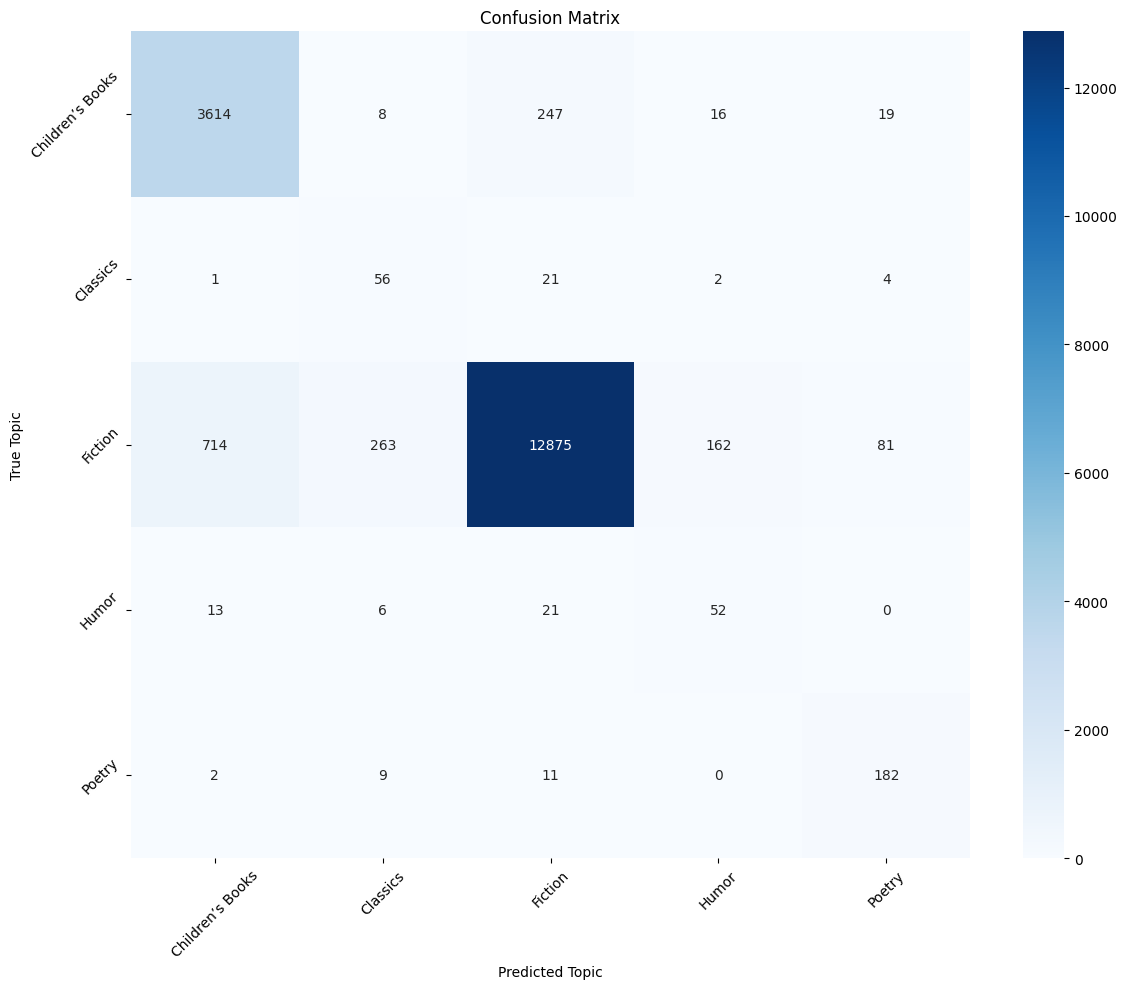

In [18]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Macro F1-Score
print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))

# Confusion Matrix
labels = sorted(list(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Topic')
plt.ylabel('True Topic')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
